<a href="https://colab.research.google.com/github/akutayaydin/Magnimind-5.1-DeepLearning/blob/main/3_Keras_CNN_Dog_or_Cat_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cat Dog Dataset

The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels for test1.zip (1 = dog, 0 = cat).

You can obtain the dataset from https://www.kaggle.com/c/dogs-vs-cats/data

This case study is adopted from https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification

### 1. Import Library

In [38]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
mypath_traindata = '/content/gdrive/My Drive/Google Colab Folder/cats_dogs_small/train'
mypath_validationdata = '/content/gdrive/My Drive/Google Colab Folder/cats_dogs_small/test'

### 2. Define Constants

In [4]:
FAST_RUN = True #False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

batch_size =32

### 3. Prepare Traning Data

In [5]:
#check for any file corruption

count_train = 0
count_validation = 0

for name in os.listdir(mypath_traindata):
  dir = os.path.join(mypath_traindata,name)
  if os.path.isdir(dir):
    if name != '.ipynb_checkpoints':
      print('Directory name:' + str(dir))
      for fname in os.listdir(dir):
        try:
          img = Image.open(str(dir) + '/' + str(fname))
          img.verify()
          count_train +=1
        except:
          print('Corrupted image: ' + str(fname))

for name in os.listdir(mypath_validationdata):
  dir = os.path.join(mypath_validationdata,name)
  if os.path.isdir(dir):
    if name != '.ipynb_checkpoints':
      print('Directory name:' + str(dir))
      for fname in os.listdir(dir):
        try:
          img = Image.open(str(dir) + '/' + str(fname))
          img.verify()
          count_validation +=1
        except:
          print('Corrupted image: ' + str(fname))

      #bad files are deleted


Directory name:/content/gdrive/My Drive/Google Colab Folder/cats_dogs_small/train/cat
Directory name:/content/gdrive/My Drive/Google Colab Folder/cats_dogs_small/train/dog
Directory name:/content/gdrive/My Drive/Google Colab Folder/cats_dogs_small/test/cat
Directory name:/content/gdrive/My Drive/Google Colab Folder/cats_dogs_small/test/dog


##### See Total In count

In [6]:
#For the small data set total numbers
print('Number of train images: ' + str(count_train))
print('Number of validation images: ' + str(count_validation))

Number of train images: 1944
Number of validation images: 531


From our data we have 12000 cats and 12000 dogs

#### See sample image

<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

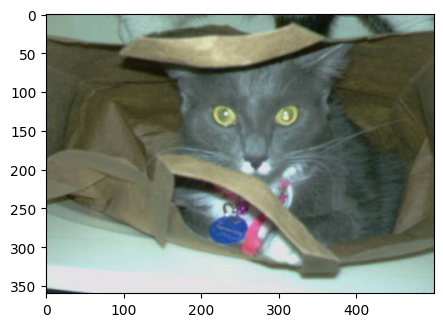

In [46]:
img = Image.open('/content/gdrive/My Drive/Google Colab Folder/cats_dogs_small/train/cat/cat2975.jpg')
#img.show()
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title

### 4. Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Input Layer**: It represent input image data. It will reshape image into single dimension array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layer reduces the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer. 

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization,MaxPool2D,Dropout,Flatten, Dense

In [9]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape = (IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS), activation = 'relu'))
model.add(BatchNormalization()) #normalize inputs
model.add(MaxPool2D(pool_size=(2,2))) #down samples the input along its spatial dimensions(width and height) by taking max value over an input window
model.add(Dropout(.2,input_shape =(2,))) #to prevent overfitting

model.add(Conv2D(32,(3,3),input_shape = (IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS), activation = 'relu'))
model.add(BatchNormalization()) #normalize inputs
model.add(MaxPool2D(pool_size=(2,2))) #down samples the input along its spatial dimensions(width and height) by taking max value over an input window
model.add(Dropout(.2,input_shape =(2,))) #to prevent overfitting

model.add(Conv2D(32,(3,3),input_shape = (IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS), activation = 'relu'))
model.add(BatchNormalization()) #normalize inputs
model.add(MaxPool2D(pool_size=(2,2))) #down samples the input along its spatial dimensions(width and height) by taking max value over an input window
model.add(Dropout(.2,input_shape =(2,))) #to prevent overfitting

model.add(Flatten())
model.add(Dense(128,activation ='relu'))
model.add(Dropout(.2,input_shape =(2,))) #to prevent overfitting
model.add(Dense(1,activation ='sigmoid'))


### 5. Callbacks

In [10]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

**Early Stop**

Keras supports the early stopping of training via a callback called EarlyStopping.

This callback allows you to specify the performance measure to monitor, the trigger, and once triggered, it will stop the training process.

The `EarlyStopping` callback is configured when instantiated via arguments.

The `monitor` allows you to specify the performance measure to monitor in order to end training.

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [24]:
earlystop = EarlyStopping(monitor='val_loss', patience=2)

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [25]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

### 6. Prepare data

Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification. 

So we will convert 1 to dog and 0 to cat

### 7. Traning Generator

In [13]:
from keras.preprocessing.image import ImageDataGenerator

In [14]:
train_datagen = ImageDataGenerator ( rescale = 1./255)

In [15]:
train_generator = train_datagen.flow_from_directory(directory = mypath_traindata,
                                                    target_size =IMAGE_SIZE,
                                                    batch_size = batch_size,
                                                    class_mode= 'categorical')

Found 1944 images belonging to 2 classes.


### Validation Generator

In [16]:
test_datagen = ImageDataGenerator (rescale = 1./255)
test_generator = test_datagen.flow_from_directory(directory = mypath_validationdata,
                                                  target_size = IMAGE_SIZE,
                                                  batch_size = batch_size,
                                                  class_mode = 'categorical')

Found 531 images belonging to 2 classes.


### 8. See how our generator work

Seem to be nice 

In [17]:
model.compile(optimizer = 'adam', loss='binary_crossentropy',metrics = ['accuracy'])

### 9. Fit Model

In [26]:
history = model.fit(train_generator,
          steps_per_epoch =10,
          epochs =5,
          validation_data = test_generator,
          validation_steps = 12,
          callbacks =[earlystop,reduce_lr])

Epoch 1/5
10/10 [==============================] - 19s 2s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 1.1806 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/5
10/10 [==============================] - 20s 2s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 1.0537 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/5
10/10 [==============================] - 18s 2s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.9429 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/5
10/10 [==============================] - 19s 2s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.8882 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/5
10/10 [==============================] - 20s 2s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.8405 - val_accuracy: 0.5000 - lr: 0.0010


### 10. Save Model

In [27]:
model.save('exercise3_keras_model_v1.h5')

### 11. Virtualize Training

In [28]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


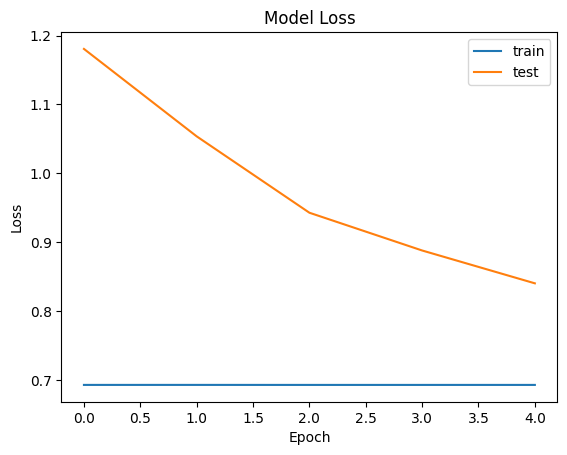

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','test'],loc= 'upper right')

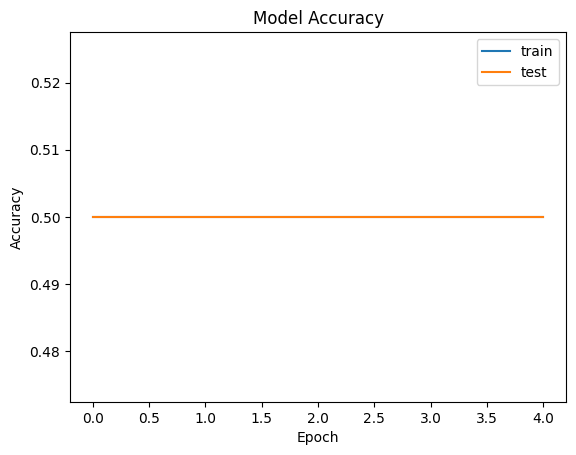

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'],loc= 'upper right')

In [42]:
accuracy = model.evaluation()

AttributeError: ignored

### 12. Prepare Testing Data

In [58]:
mypath_predicttestdata = '/content/gdrive/My Drive/Google Colab Folder/cats_dogs_small/test_predict'

In [53]:
test_predict_datagen = ImageDataGenerator(rescale= 1./255)

In [63]:
test_predict_generate = test_predict_datagen.flow_from_directory(directory = mypath_predicttestdata,
                                                                 target_size = IMAGE_SIZE,
                                                                 batch_size = batch_size,
                                                                 class_mode ='categorical')

Found 0 images belonging to 0 classes.


### 13. Create Testing Generator

### 14. Predict

#### Virtualize Result

### 15. See predicted result with images